CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **four** hidden layers with tapering width [256, 128, 64, 32] neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers and implement L2 weight decay with **weight_decay = 0.01**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from PartA.common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

> Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [ ]:
from PartA.common_utils import split_dataset, preprocess_dataset

# Load the preprocessed audio features CSV
df = pd.read_csv("audio_gtzan.csv")

# Extract label (genre) from filename column
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])

# Drop both filename and label from features to avoid leakage
columns_to_drop = ["filename", "label"]
test_size = 0.25 # 25% for test set
random_state = 42 # set a fixed random seed for reproducibility

# Split the dataset into training and test sets
df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)

# Preprocess the input features
X_train, X_test = preprocess_dataset(df_train, df_test)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **'Adam'** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **5**.

1. Define a Pytorch Dataset and Dataloaders.  

In [ ]:
from PartA.common_utils import AudioDataset

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# 1. Create training and test datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# 2. Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


2. Next, define the model, optimizer and loss function.

In [5]:
# TODO: Enter your code here
model = MLP(input_dim=57, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from PartA.common_utils import EarlyStopper

# Force use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping setup
early_stopper = EarlyStopper(patience=5, min_delta=0.0)

# Track metrics
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

for epoch in range(100):
    model.train()
    correct = 0
    total = 0
    train_loss_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        predicted = (preds > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        # Accumulate loss (for averaging later)
        train_loss_total += loss.item() * y_batch.size(0)

    train_accuracy = correct / total
    avg_train_loss = train_loss_total / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)

    # ----- Evaluate on test set -----
    model.eval()
    correct = 0
    total = 0
    test_loss_total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            test_loss_total += loss.item() * y_batch.size(0)

            predicted = (preds > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_accuracy = correct / total
    avg_test_loss = test_loss_total / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}, Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

    # Early stopping
    if early_stopper.early_stop(avg_test_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch 1: Train Acc = 0.5900, Test Acc = 0.7960, Train Loss = 0.6791, Test Loss = 0.6508
Epoch 2: Train Acc = 0.8220, Test Acc = 0.8460, Train Loss = 0.5930, Test Loss = 0.4793
Epoch 3: Train Acc = 0.8733, Test Acc = 0.8980, Train Loss = 0.3872, Test Loss = 0.2681
Epoch 4: Train Acc = 0.9147, Test Acc = 0.9220, Train Loss = 0.2263, Test Loss = 0.1958
Epoch 5: Train Acc = 0.9480, Test Acc = 0.9380, Train Loss = 0.1423, Test Loss = 0.1641
Epoch 6: Train Acc = 0.9607, Test Acc = 0.9400, Train Loss = 0.1189, Test Loss = 0.1415
Epoch 7: Train Acc = 0.9687, Test Acc = 0.9520, Train Loss = 0.0980, Test Loss = 0.1144
Epoch 8: Train Acc = 0.9807, Test Acc = 0.9600, Train Loss = 0.0772, Test Loss = 0.1072
Epoch 9: Train Acc = 0.9820, Test Acc = 0.9600, Train Loss = 0.0685, Test Loss = 0.0938
Epoch 10: Train Acc = 0.9847, Test Acc = 0.9660, Train Loss = 0.0575, Test Loss = 0.0865
Epoch 11: Train Acc = 0.9880, Test Acc = 0.9680, Train Loss = 0.0504, Test Loss = 0.0794
Epoch 12: Train Acc = 0.9887, 

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

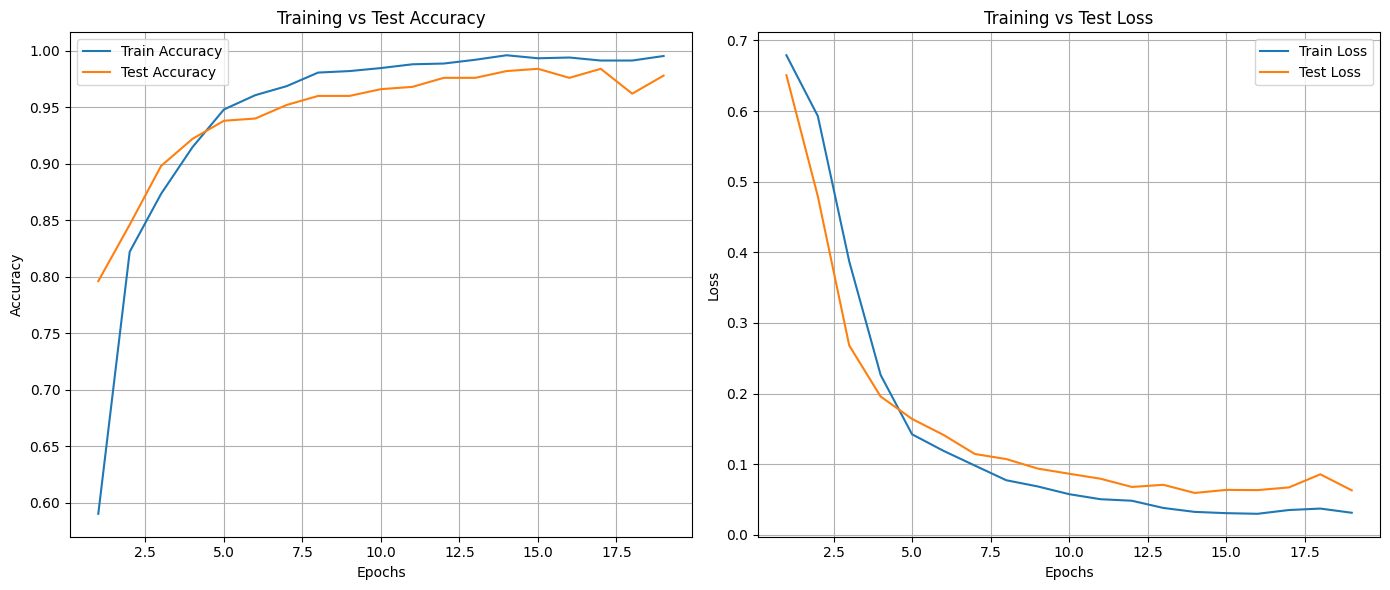

In [7]:
import matplotlib.pyplot as plt

# Define the range of epochs (x-axis)
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(14, 6))

# --- Plot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

For accuracy, both training and test accuracy initially increase rapidly in the first few epochs. They converge and reach near perfect accuracy roughly 5 epochs in. As both curves align similarly,  it suggests that the model generalises well without overfitting.

For loss, both curves reach near 0 around 5 epochs in. This is consistent with the high accuracy scores, and suggest good generalisation and no significant overfitting from the close alignment of the 2 curves.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal learning rate for the Adam optimizer. Find the optimal learning rate by training the neural network and evaluating the performances for different learning rates. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

>Plot mean cross-validation accuracies and mean cross-validation AUC scores on the final epoch for different learning rates as scatter plots. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}. Keep batch_size fixed at 128. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration. Finally, select the optimal learning rate and state a reason for your selection.

1. Define different folds for different learning rates to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[learning_rate] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[learning_rate] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[learning_rate] and y_val_dict[learning_rate] is a list of labels for the different folds.

In [10]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Define the learning rates to evaluate
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

# Initialize dictionaries to store scaled data per learning rate
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over learning rates
for lr in learning_rates:
    X_train_scaled_dict[lr] = []
    X_val_scaled_dict[lr] = []
    y_train_dict[lr] = []
    y_val_dict[lr] = []
    
    # Split into 5 folds
    for train_idx, val_idx in kf.split(X_train):
        # Extract train and validation folds
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold = y_train[val_idx]

        # Re-scale based on train fold only
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Append to dict
        X_train_scaled_dict[lr].append(X_train_fold_scaled)
        X_val_scaled_dict[lr].append(X_val_fold_scaled)
        y_train_dict[lr].append(y_train_fold)
        y_val_dict[lr].append(y_val_fold)


2. Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [ ]:
from PartA.common_utils import AudioDataset, MLP
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import time
import torch
from torch import nn

batch_size = 128
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr_acc_dict = {}
lr_auc_dict = {}
lr_time_dict = {}

for lr in learning_rates:
    acc_list = []
    auc_list = []
    time_list = []

    for fold in range(5):
        # Fold data
        X_train_fold = X_train_scaled_dict[lr][fold]
        y_train_fold = y_train_dict[lr][fold]
        X_val_fold   = X_val_scaled_dict[lr][fold]
        y_val_fold   = y_val_dict[lr][fold]

        # Datasets / loaders
        train_dataset = AudioDataset(X_train_fold, y_train_fold)
        val_dataset   = AudioDataset(X_val_fold,   y_val_fold)
        train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        # Model / opt / loss
        model = MLP(input_dim=X_train_fold.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        loss_fn = nn.BCELoss()

        # Train
        for epoch in range(num_epochs):
            model.train()
            # Only time the *last epoch* training step
            if epoch == num_epochs - 1:
                t0 = time.time()

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epoch == num_epochs - 1:
                t_last_epoch = time.time() - t0  # seconds

        # Evaluate on validation (final epoch)
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                preds = model(X_batch)                  # (B,1) sigmoid probs
                all_preds.append(preds.cpu().numpy())   # list of (B,1)
                all_labels.append(y_batch.numpy())      # list of (B,1)

        # Stack and flatten to 1D
        y_true = np.vstack(all_labels).ravel()
        y_prob = np.vstack(all_preds).ravel()
        y_pred = (y_prob > 0.5).astype(int)

        # Metrics
        acc = accuracy_score(y_true, y_pred)

        # Guard for AUC if a fold is single-class (rare with KFold, but safe)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = np.nan

        # Save
        acc_list.append(acc)
        auc_list.append(auc)
        time_list.append(t_last_epoch)

    lr_acc_dict[lr] = acc_list
    lr_auc_dict[lr] = auc_list
    lr_time_dict[lr] = time_list


3. Plot scatterplot of mean cross validation accuracies and AUC scores on the final epoch for the different learning rates. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}.

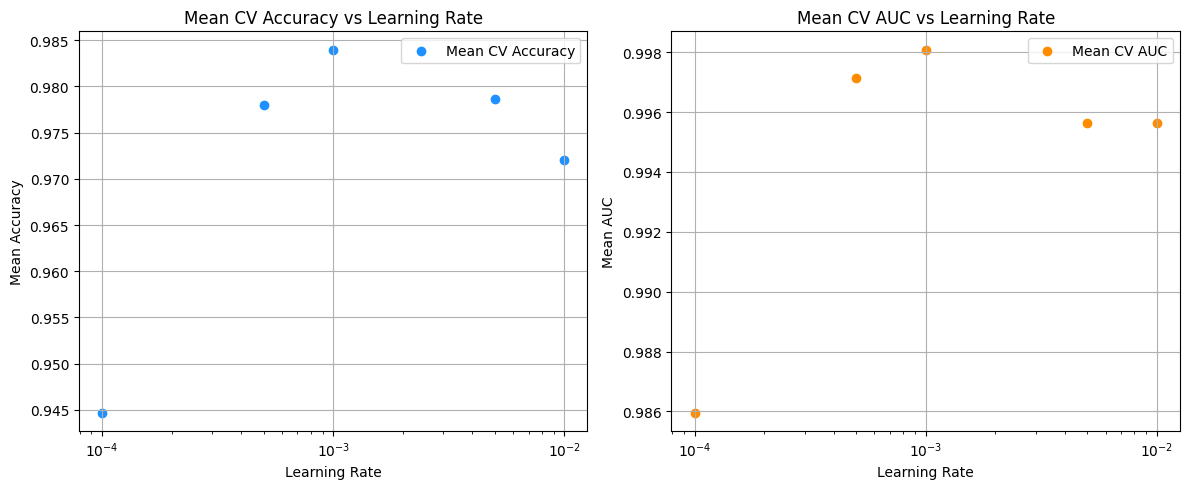

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Learning rates (to keep order consistent)
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

# Compute means
mean_accuracies = [np.mean(lr_acc_dict[lr]) for lr in learning_rates]
mean_aucs       = [np.nanmean(lr_auc_dict[lr]) for lr in learning_rates]  # Use nanmean in case some AUCs are NaN

# Plot mean accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(learning_rates, mean_accuracies, color='dodgerblue', label='Mean CV Accuracy')
plt.title('Mean CV Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.xscale('log')  # log scale helps visualize small LR steps
plt.grid(True)
plt.legend()

# Plot mean AUC
plt.subplot(1, 2, 2)
plt.scatter(learning_rates, mean_aucs, color='darkorange', label='Mean CV AUC')
plt.title('Mean CV AUC vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean AUC')
plt.xscale('log')  # log scale for consistency
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration.

Training Time per Last Epoch:


,Learning Rate,Avg Time per Last Epoch (s)
0,0.0001,0.034575
1,0.0005,0.039965
2,0.0010,0.036164
3,0.0050,0.042269
4,0.0100,0.080182


Optimal Learning Rate selected: 0.001


<Figure size 600x600 with 0 Axes>

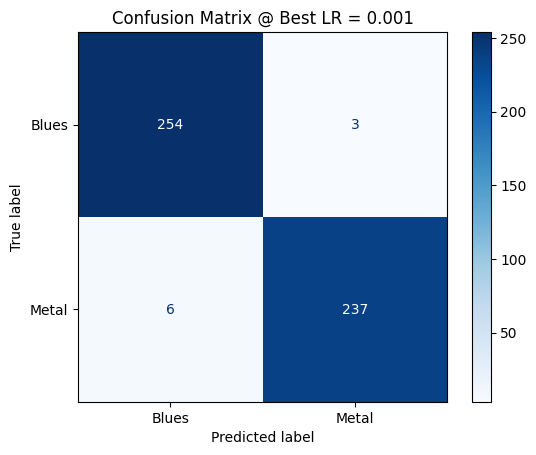

In [18]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Time Comparison Table
# Average time per learning rate (in seconds)
mean_times = {lr: np.mean(times) for lr, times in lr_time_dict.items()}

# Create and display the DataFrame
time_df = pd.DataFrame({
    'Learning Rate': list(mean_times.keys()),
    'Avg Time per Last Epoch (s)': list(mean_times.values())
}).sort_values(by='Learning Rate')

print("Training Time per Last Epoch:")
display(time_df)

### Confusion Matrix for Best Learning Rate 
best_lr = max(lr_auc_dict, key=lambda lr: np.nanmean(lr_auc_dict[lr]))
print(f"Optimal Learning Rate selected: {best_lr}")

# Prepare full train/test sets again (no CV now)
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])
columns_to_drop = ["filename", "label"]

from PartA.common_utils import split_dataset, preprocess_dataset
df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.25, random_state=42)
X_train, X_test = preprocess_dataset(df_train, df_test)

# Create dataset and loader
train_dataset = AudioDataset(X_train, pd.Series(y_train))
test_dataset  = AudioDataset(X_test,  pd.Series(y_test))
train_loader  = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=128, shuffle=False)

# Train model using best learning rate
model = MLP(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=0.01)
loss_fn = nn.BCELoss()

# Training loop (short training: say 30 epochs)
for epoch in range(30):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.numpy())

# Flatten
y_true = np.vstack(all_labels).ravel()
y_prob = np.vstack(all_preds).ravel()
y_pred = (y_prob > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blues', 'Metal'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix @ Best LR = {best_lr}')
plt.grid(False)
plt.show()

5. Select the optimal learning rate and state a reason for your selection.

The optimal learning rate is 0.001. This is because it has the highest mean AUC. Out of all learning rates, 0.001 has the best average AUC over the 5 folds, indicating a consistent high performance. It also has the highest cross-validation accuracy out of the 5 learning rates.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 5-layer network (4 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [20]:
# TODO: Enter your code here

> Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Maintain the tapering pattern (e.g., if first layer is 256, use [256, 128, 64, 32]). Limit the search space of the first layer neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Add ROC curve plotting for the final selected architecture.

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [20]:
first_layer_options = [64, 128, 256]
batch_size = 128
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

width_acc_dict = {}
width_auc_dict = {}

for width in first_layer_options:
    hidden_sizes = [width, width // 2, width // 4, width // 8]  # maintain tapering pattern
    acc_list = []
    auc_list = []

    for fold in range(5):
        # Extract fold data
        X_train_fold = X_train_scaled_dict[best_lr][fold]
        y_train_fold = y_train_dict[best_lr][fold]
        X_val_fold   = X_val_scaled_dict[best_lr][fold]
        y_val_fold   = y_val_dict[best_lr][fold]

        # Datasets & loaders
        train_dataset = AudioDataset(X_train_fold, pd.Series(y_train_fold))
        val_dataset   = AudioDataset(X_val_fold,   pd.Series(y_val_fold))
        train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        # Model
        model = MLP(input_dim=X_train_fold.shape[1], hidden_sizes=hidden_sizes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=0.01)
        loss_fn = torch.nn.BCELoss()

        # Train
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                preds = model(X_batch)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y_batch.numpy())

        # Flatten
        y_true = np.vstack(all_labels).ravel()
        y_prob = np.vstack(all_preds).ravel()
        y_pred = (y_prob > 0.5).astype(int)

        # Metrics
        acc = accuracy_score(y_true, y_pred)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = np.nan

        acc_list.append(acc)
        auc_list.append(auc)

    width_acc_dict[width] = acc_list
    width_auc_dict[width] = auc_list


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Limit the search space of the first layer neurons to {64, 128, 256}.

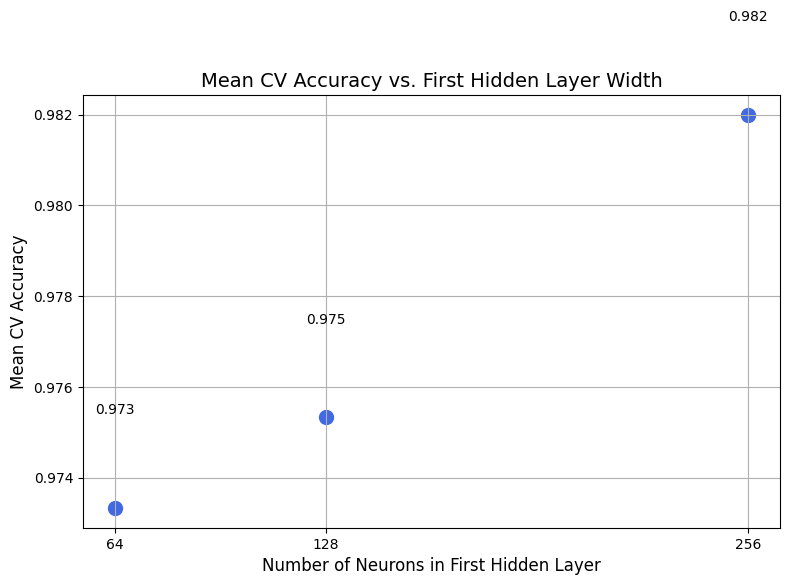

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean accuracy across folds for each hidden layer width
mean_accs = {width: np.mean(accs) for width, accs in width_acc_dict.items()}

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_accs.keys(), mean_accs.values(), color='royalblue', s=100)

# Annotate each point
for width, acc in mean_accs.items():
    plt.text(width, acc + 0.002, f"{acc:.3f}", ha='center', va='bottom', fontsize=10)

# Plot formatting                                                                                                                                                                                                                                                                                                                                               
plt.title("Mean CV Accuracy vs. First Hidden Layer Width", f    ontsize=14)
plt.xlabel("Number of Neurons in First Hidden Layer", fontsize=12)
plt.ylabel("Mean CV Accuracy", fontsize=12)
plt.xticks([64, 128, 256])
plt.grid(True)
plt.tight_layout()
plt.show()


> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [24]:
import numpy as np
import pandas as pd

first_layer_options = [64, 128, 256]

summary_rows = []
for w in first_layer_options:
    accs = np.asarray(width_acc_dict[w], dtype=float)
    aucs = np.asarray(width_auc_dict[w], dtype=float)
    summary_rows.append({
        "width": w,
        "mean_acc": np.nanmean(accs), "std_acc": np.nanstd(accs),
        "mean_auc": np.nanmean(aucs), "std_auc": np.nanstd(aucs),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("width")
print(summary_df.to_string(index=False))

# Select by mean AUC, then mean accuracy, then fewer params (smaller width) as a final tie-breaker
best = sorted(
    summary_rows,
    key=lambda r: (r["mean_auc"], r["mean_acc"], -r["width"]),  # -width so larger wins only if better metrics
    reverse=True
)[0]

best_width = best["width"]
best_auc   = best["mean_auc"]
best_acc   = best["mean_acc"]
print(f"Selected width: {best_width} | mean AUC={best_auc:.4f} (±{best['std_auc']:.4f}), "
      f"mean Acc={best_acc:.4f} (±{best['std_acc']:.4f})")

 width  mean_acc  std_acc  mean_auc  std_auc
    64  0.973333 0.012649  0.994699 0.002080
   128  0.975333 0.008844  0.996815 0.001083
   256  0.982000 0.008589  0.997486 0.001482
Selected width: 256 | mean AUC=0.9975 (±0.0015), mean Acc=0.9820 (±0.0086)


The best performance was achieved with **256** neurons, which resulted in the highest mean validation accuracy at 0.982.
The accuracy did not improve at all with smaller sizes, suggesting that 256 neurons provides sufficient capacity without overfitting. To corroborate this, 256 neurons also achieved the best AUC score of 0.9975, indicating good class discrimination ability.

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. Add ROC curve plotting for the final selected architecture.
Note: use this optimal number of neurons for the rest of the experiments.

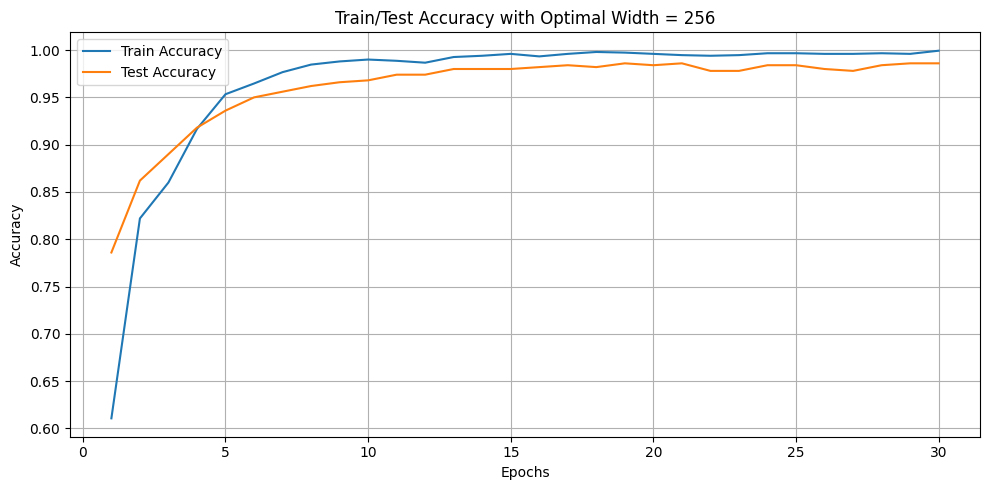

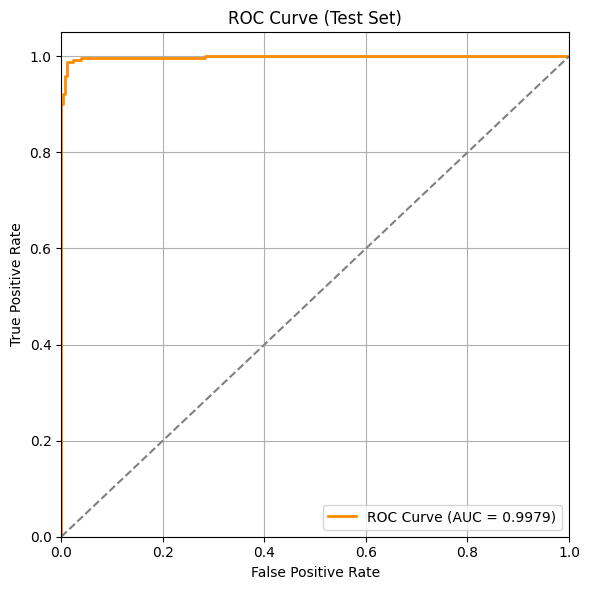

In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from torch.utils.data import DataLoader
from PartA.common_utils import MLP, split_dataset, preprocess_dataset, AudioDataset

# 1. Reload and preprocess the dataset
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])
columns_to_drop = ["filename", "label"]

df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.25, random_state=42)
X_train, X_test = preprocess_dataset(df_train, df_test)

train_dataset = AudioDataset(X_train, pd.Series(y_train))
test_dataset  = AudioDataset(X_test,  pd.Series(y_test))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

# 2. Model setup
# best_lr = 0.001  # uncomment this if running this cell without previous cells
# best_wdith = 256 # uncomment this if running this cell without previous cells

hidden_sizes = [best_width, best_width // 2, best_width // 4, best_width // 8]
model = MLP(input_dim=X_train.shape[1], hidden_sizes=hidden_sizes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=0.01)
loss_fn = torch.nn.BCELoss()

# 3. Training loop with accuracy tracking
num_epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted = (preds > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    train_accuracies.append(correct / total)

    # Evaluate test accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            predicted = (preds > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    test_accuracies.append(correct / total)

# 4. Plot train/test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Train/Test Accuracy with Optimal Width = {best_width}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 5. ROC Curve (on test set)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.numpy())

y_true = np.vstack(all_labels).ravel()
y_prob = np.vstack(all_preds).ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Please use the 'audio_test.wav' as a test sample. Preprocess the data using the function 'extract_features' in common_utils.py. 
Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations. 
Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [12]:
# TODO: Enter your code here

> Install and import shap

In [26]:
# !pip install shap

import shap

> Preprocess 'audio_test.wav' in the folder 'audio' using the function 'extract_features' in common_utils.py. Use a pandas dataframe to store the features, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [30]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [31]:
from PartA.common_utils import extract_features

df = extract_features('./audio_test.wav')
size_row, size_column = df.shape

print(f"Extracted feature shape: {size_row} row(s), {size_column} column(s)")

Extracted feature shape: 1 row(s), 58 column(s)


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [32]:
import pandas as pd
import numpy as np
from PartA.common_utils import extract_features, split_dataset, preprocess_dataset

# 1) Extract features from the test audio (single row)
df_test = extract_features("./audio_test.wav")           # shape (1, 58)
df_test_features = df_test.drop(columns=["filename"])    # shape (1, 57)

# 2) Load full dataset and rebuild the *same* train split used for model training
df_full = pd.read_csv("audio_gtzan.csv")
df_full["label"] = df_full["filename"].apply(lambda x: x.split(".")[0])

# Drop filename & label from X, but do it via split_dataset so labels are encoded
# keep the same test_size and random_state used earlier (0.25, 42)
df_train, y_train, df_unused, y_unused = split_dataset(
    df_full, columns_to_drop=["filename", "label"], test_size=0.25, random_state=42
)
# df_train are the training features used to fit the scaler

# 3) Ensure column order match between train and the single test row
df_test_features = df_test_features[df_train.columns]

# 4) Fit scaler on *training features* and transform the single test row
X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test_features)

# 5) Save as float32 numpy and print shape
X_audio_test = X_test_scaled.astype(np.float32)          # expected shape (1, 57)
print("Test audio shape:", X_audio_test.shape)


Test audio shape: (1, 57)


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [33]:
# IMPT! Run previous questions cells before this one to define best_width and best_lr!
# Use the trained `model` from earlier (already fitted with best_width & best_lr)
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

x_test_tensor = torch.tensor(X_audio_test, dtype=torch.float32, device=device)

with torch.no_grad():
    prob = model(x_test_tensor).item()   # sigmoid probability in [0,1]
    pred_label = int(prob > 0.5)         # REQUIRED variable name

print(f"Pred prob={prob:.4f}, Predicted Label={pred_label}")

Pred prob=0.0619, Predicted Label=0


\# TODO: \<Enter your answer here\>

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 


Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


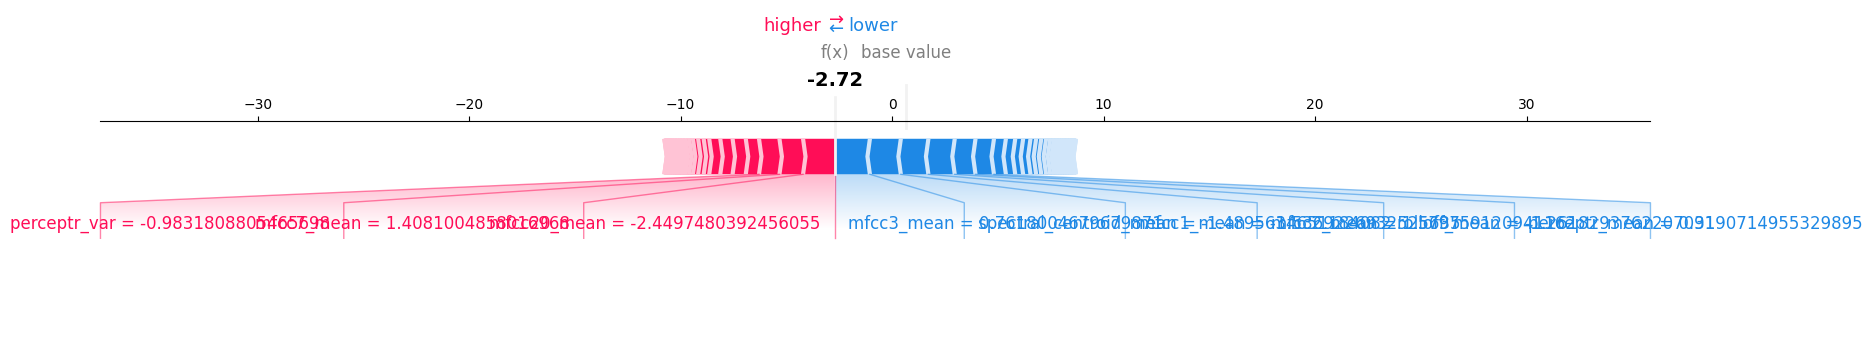

Saved interactive plot to force_plot.html

Top + (push toward predicted class):
                SHAP
mfcc20_mean   1.4912
mfcc7_mean    1.1163
perceptr_var  0.9664
rms_var       0.6257
mfcc16_mean   0.6247

Top - (push away from predicted class):
                          SHAP
mfcc3_mean             -1.6709
spectral_centroid_mean -1.4618
mfcc1_mean             -1.3037
mfcc2_mean             -1.2457
rolloff_mean           -0.9824


In [44]:
# --- SHAP local explanation for the single test audio ---
import numpy as np
import pandas as pd
import torch
import shap
from IPython.display import display, HTML

# Device & eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()   # keep grads enabled (don't use torch.no_grad() for SHAP)

# Background set (use scaled training data; subset for speed)
background_size = min(100, X_train.shape[0])
X_bg = torch.tensor(X_train[:background_size], dtype=torch.float32, device=device)   # (B, 57)

# Single test instance (scaled)
x_test_tensor = torch.tensor(X_audio_test, dtype=torch.float32, device=device)      # (1, 57)

# Wrapper that returns logits (pre-sigmoid) for DeepExplainer
class LogitModel(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, x):
        logits, _ = self.base(x, return_logits=True)   
        return logits                                  # shape (B, 1)

logit_model = LogitModel(model).to(device)

# Build DeepExplainer (PyTorch backend)
explainer = shap.DeepExplainer(logit_model, X_bg)

# Compute SHAP values for the single test instance
shap_values = explainer.shap_values(x_test_tensor)   # list per output; here len==1

# Prepare values for plotting (ensure 1D numpy vectors)
# expected_value -> plain float
base_val = explainer.expected_value[0]
if isinstance(base_val, torch.Tensor):
    base_val = base_val.detach().cpu().item()

# shap values -> 1D numpy of length = n_features (57)
sv = shap_values[0]
if isinstance(sv, torch.Tensor):
    sv = sv.detach().cpu().numpy()
sv = np.asarray(sv)
# sv might be (57,1) or (1,57) or (1,1,57) depending on versions; make it 1D
sv = sv.reshape(-1)

# feature names & feature row (must match training column order)
feature_names = list(df_train.columns)   # 57 names
features_row = np.asarray(X_audio_test[0])  # (57,)

# Safety check
assert len(sv) == len(features_row) == len(feature_names), \
    f"Mismatch: sv={len(sv)}, x={len(features_row)}, names={len(feature_names)}"

# Force plot (static matplotlib version)
shap.initjs()
shap.force_plot(
    base_value=base_val,
    shap_values=sv,
    features=features_row,
    feature_names=feature_names,
    matplotlib=True
)

# interactive plot version
interactive_plot = shap.force_plot(
    base_value=base_val,      # plain float
    shap_values=sv,           # 1D numpy, length = n_features
    features=features_row,    # 1D numpy, same length
    feature_names=feature_names
)
display(interactive_plot)     # renders an interactive force plot

# Uncomment this, drag html file to a browser tab to see the full plot !
# shap.save_html("force_plot.html", interactive_plot)
# print("Saved interactive plot to force_plot.html")


# Top-5 positive/negative features (for your write-up)
feat_series = pd.Series(sv, index=feature_names)
top_pos = feat_series.sort_values(ascending=False).head(5)
top_neg = feat_series.sort_values(ascending=True).head(5)

print("\nTop + (push toward predicted class):")
print(top_pos.round(4).to_frame("SHAP"))

print("\nTop - (push away from predicted class):")
print(top_neg.round(4).to_frame("SHAP"))


In the force plot, red features increased the output toward the predicted class and blue features decreased it. The largest positive pushes came from mfcc20_mean, mfcc7_mean, perceptr_var, rms_var, and mfcc16_mean, while mfcc3_mean, spectral_centroid_mean, mfcc1_mean, mfcc2_mean, and rolloff_mean counteracted the prediction.

Top 5 Positive Influences (push toward predicted class) 
- mfcc20_mean: Captures high-frequency timbral detail; distinguishes sharp metallic textures common in metal.
- mfcc7_mean: Reflects mid-level frequency patterns; usually indicating complex vocal or instrument harmonics.
- perceptr_var: High percussive variance suggests strong rhythmic activity, characteristic of heavy metal.
- rms_var: Variability in energy levels may indicate dynamic intensity shifts typical in metal.
- mfcc16_mean: Higher-order MFCCs capture fine-grained spectral structure, useful for differentiating distorted instrument sounds.

Top 5 Negative Influences
- mfcc3_mean: Low-order MFCC tied to spectral slope; more consistent in simpler, smoother textures like blues.
- spectral_centroid_mean: Indicates brightness; lower values (pushing away from metal) reflect darker, warmer tones typical of blues.
- mfcc1_mean: Captures fundamental frequency energy; flatter in blues.
- mfcc2_mean: Closely linked to overall spectral shape, more stable in less complex genres.
- rolloff_mean: Lower rolloff points to reduced high-frequency energy, as often found in blues.

Why this makes sense: 
Metal tends to be brighter, with more high-frequency content, stronger percussive transients, and richer/distorted timbres; blues trends warmer/darker with cleaner spectra. MFCCs summarise these differences, while centroid/rolloff directly capture the brightness/harmonic spread. The SHAP attributions therefore align with these genre characteristics.